In [115]:
import pandas as pd
import utils
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torchmetrics.regression import MeanSquaredError,R2Score
from torchinfo import summary
from sklearn.preprocessing import StandardScaler

In [116]:
featureDF=pd.read_csv('feature.csv')
targetDF=pd.read_csv('target.csv')

In [117]:
featureDF.shape,targetDF.shape

((153290, 5), (153290, 5))

In [118]:
featureDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153290 entries, 0 to 153289
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   일시          153290 non-null  object 
 1   최저기온(°C)    153290 non-null  float64
 2   최고기온(°C)    153290 non-null  float64
 3   일강수량(mm)    153290 non-null  float64
 4   평균 상대습도(%)  153290 non-null  float64
dtypes: float64(4), object(1)
memory usage: 5.8+ MB


In [119]:
featureDF=featureDF.drop(columns=['일시'])
featureDF.head()

,최저기온(°C),최고기온(°C),일강수량(mm),평균 상대습도(%)
0,15.3,23.6,0.0,68.0
1,13.7,23.9,0.0,64.9
2,9.6,22.4,0.0,78.0
3,12.0,21.3,0.0,92.8
4,11.2,22.9,0.1,89.4


In [120]:
#targetDF=targetDF.drop(columns=['일시','평균 상대습도(%)','일강수량(mm)'])
targetDF=targetDF[['최고기온(°C)']]
targetDF.head()

,최고기온(°C)
0,23.9
1,22.4
2,21.3
3,22.9
4,22.3


## 데이터 셋 분리 후 텐서화

In [121]:
SS=utils.SeperateSet(featureDF,targetDF)
X_train,X_val,X_test,y_train,y_val,y_test=SS.run()

In [122]:
print(f'X_train : {X_train.shape} X_val :{X_val.shape} X_test:{X_test.shape}')
print(f'y_train : {y_train.shape} y_val :{y_val.shape} y_test:{y_test.shape}')

X_train : (98105, 4) X_val :(24527, 4) X_test:(30658, 4)
y_train : (98105, 1) y_val :(24527, 1) y_test:(30658, 1)


In [123]:
# scaler=StandardScaler()
# scaler.fit(X_train)
# X_train=pd.DataFrame(scaler.transform(X_train))
# X_val=pd.DataFrame(scaler.transform(X_val))
# X_test=pd.DataFrame(scaler.transform(X_test))


In [124]:
trainDS=utils.MyDataSet(X_train,y_train)
valDS=utils.MyDataSet(X_val,y_val)
testDS=utils.MyDataSet(X_test,y_test)

In [125]:
trainDL=DataLoader(trainDS,batch_size=64)
valDL=DataLoader(valDS,batch_size=len(valDS))

## 모델로딩

In [126]:
model=utils.DynamicsModel(featureDF.shape[1],targetDF.shape[1],nums=[2000,1000])
optimizer=optim.Adam(model.parameters(),lr=0.2)

In [127]:
summary(model,input_size=X_train.shape)

Layer (type:depth-idx)                   Output Shape              Param #
DynamicsModel                            [98105, 1]                --
├─Linear: 1-1                            [98105, 2000]             10,000
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-1                       [98105, 1000]             2,001,000
├─Linear: 1-3                            [98105, 1]                1,001
Total params: 2,012,001
Trainable params: 2,012,001
Non-trainable params: 0
Total mult-adds (G): 197.39
Input size (MB): 1.57
Forward/backward pass size (MB): 2355.30
Params size (MB): 8.05
Estimated Total Size (MB): 2364.92

In [128]:
# 스케쥴러
scheduler=lr_scheduler.ReduceLROnPlateau(optimizer,patience=10,factor=0.6)

In [129]:
lossf=MeanSquaredError()
scoref=R2Score(num_outputs=targetDF.shape[1])

In [130]:
EPOCH=1000
trainmodel=utils.Train_val(trainDL,valDL,model,optimizer,lossf,scoref)
History=trainmodel.train(EPOCH,scheduler,modelnum='max2')

[1/1000]
train loss 67282647.54333782, train score -1724094.0335247458
val loss 38.67550277709961, val score 0.000558316707611084
scheduler.num_bad_epochs 0/10
[2/1000]
train loss 1220.3999534154048, train score -28.251407376551892
val loss 40.190208435058594, val score -0.038584232330322266
scheduler.num_bad_epochs 1/10
[3/1000]
train loss 105.36637457756147, train score -1.8916904471780611
val loss 41.29402160644531, val score -0.06710875034332275
scheduler.num_bad_epochs 2/10
[4/1000]
train loss 2640.5823378827317, train score -76.66170107952847
val loss 42.25160598754883, val score -0.09185433387756348
scheduler.num_bad_epochs 3/10


KeyboardInterrupt: 

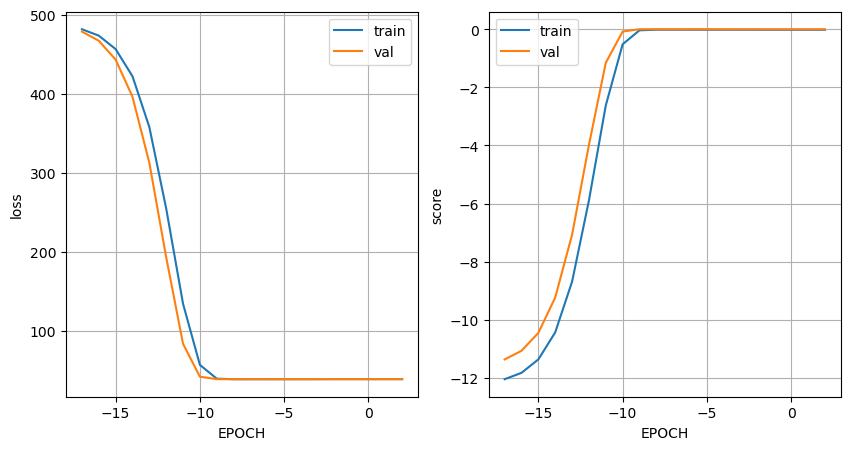

In [97]:
plothistoy=utils.Plot_History(History)
plothistoy.draw(num=20)

In [98]:
testDL=DataLoader(testDS,batch_size=X_test.shape[0])
MAX_Model = torch.load('model/best_modelmax1.pth', weights_only=False)
for feature,target in testDL:
    test_y=MAX_Model(feature)
    loss=lossf(test_y,target)
    score=scoref(test_y,target)
    print(f'test loss {loss}, test score {score}')

test loss 7.3169636726379395, test score 0.8119864463806152
